# Create a mesh using a dataset

## Import libraries and load dataset

In [2]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import pandas as pd

## Read data

In [3]:
maritime_data = pd.read_csv("./Topography_arcachon/maritime_data.csv", sep=",", header=2)
earth_data = pd.read_csv("./Topography_arcachon/earth_data copy.csv", sep=",", header=3)

## Process datas
Transform csv data to numpy arrays to be plotted

Correct for real maximum water depth (opposite of dataset depth)

In [4]:
maritime_data.columns = ["long", "lat", "depth"]
maritime_data["depth"] = maritime_data["depth"]-1.9860
maritime_depth = maritime_data["depth"]
maritime_long = maritime_data["long"].to_numpy()
maritime_lat = maritime_data["lat"].to_numpy()

earth_data=pd.DataFrame(np.array(earth_data),columns=['lat','long','depth','iteration'])
earth_depth = earth_data["depth"].to_numpy()
earth_long = earth_data["long"].to_numpy()
earth_lat = earth_data["lat"].to_numpy()

Changing scale

In [5]:
maritime_depth = maritime_depth*30
maritime_long = maritime_long*111000        
maritime_lat = maritime_lat*111000           

earth_depth=earth_depth*30
earth_lat=earth_lat*111000
earth_long=earth_long*111000

# Plot data sets

Plot maritime data

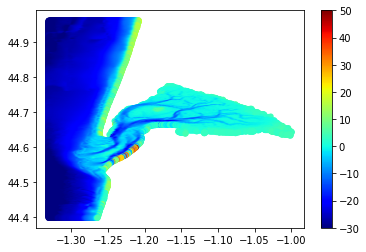

In [6]:
plt.figure()
plt.scatter(maritime_long/111000, maritime_lat/111000, c=maritime_depth/30, cmap="jet",linewidths=0.0000005)
plt.clim(vmin=-30,vmax=50)
plt.colorbar()
plt.savefig("Mar_data.png")
plt.show()

Plot topography data

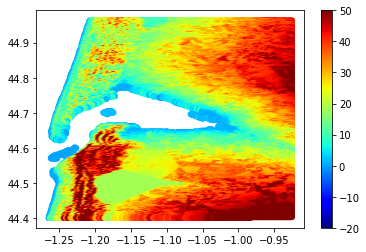

In [7]:
plt.figure()
plt.scatter(earth_long/111000, earth_lat/111000, c=earth_depth/30, cmap="jet",linewidths=0.0000005)
plt.clim(vmin=-20,vmax=50)
plt.colorbar()
plt.savefig("Topo_data.png")
plt.show()


Plot topography and maritime data

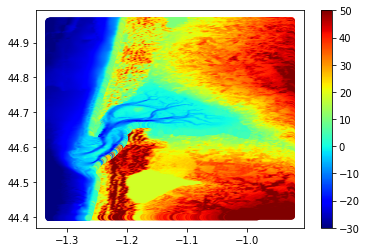

In [8]:
plt.figure()
plt.scatter(np.concatenate((earth_long/111000,maritime_long/111000)), np.concatenate((earth_lat/111000,maritime_lat/111000)), c=np.concatenate((earth_depth/30,maritime_depth/30)), cmap="jet",linewidths=0.0000005)
plt.clim(vmin=-30,vmax=50)
plt.colorbar()
plt.savefig("Topo_Mar_data.png")
plt.show()

# Select the data set to make the mesh and makes it smooth 

Select the data set 


options=0 # 0: earth+maritime, 1: earth, other cases: maritime


In [9]:
options=0 # 0: earth+maritime, 1: earth, other cases: maritime
if options==0:
    long=np.concatenate((maritime_long,earth_long))
    lat=np.concatenate((maritime_lat,earth_lat))
    depth=np.concatenate((maritime_depth,earth_depth))
elif options==1:
    long=earth_long
    lat=earth_lat
    depth=earth_depth
else :
    long=maritime_long
    lat=maritime_lat
    depth=maritime_depth


# Utilisation of the k-nearest neighbors and its depth average to make the data set smooth

In [10]:
from sklearn.neighbors import NearestNeighbors

def smooth_grid(points,k_neigh=7):
    points = points[points[:, 1].argsort()]
    points = points[points[:, 0].argsort(kind='mergesort')]

    new_long=[]
    new_lat=[]
    new_depth=[]

    long=points[:,0]
    lat=points[:,1]
    matrix=np.array([long,lat]).T

    neigh = NearestNeighbors(n_neighbors=k_neigh)
    neigh.fit(matrix) 
    NearestNeighbors(algorithm='auto', leaf_size=30)

    for i in range(len(matrix)):
        neighbors=neigh.kneighbors([[matrix[i,0],matrix[i,1]]])[1][0]
        average_long=np.sum([points[k,0] for k in neighbors]+points[i,0])/(k_neigh+1)
        average_lat=np.sum([points[k,1] for k in neighbors]+points[i,1])/(k_neigh+1)
        average_depth=np.sum([points[k,2] for k in neighbors]+points[i,2])/(k_neigh+1)
        new_long.append(average_long)
        new_lat.append(average_lat)
        new_depth.append(average_depth)
    
    return np.array([new_long,new_lat,new_depth]).T



In [11]:
points = np.array([long,lat,depth]).T
points=smooth_grid(points)

## Generating the Mesh

In [12]:
import pyvista as pv

cloud = pv.PolyData(points)
grid = cloud.delaunay_2d(alpha=2500)   # We use the Delaunay method to make the mesh
print("Number of points",grid.number_of_points)
print("Number of cells",grid.number_of_cells)

Number of points 138317
Number of cells 275440


# Coloring the cells


In [13]:
import vtk
colors = vtk.vtkIntArray()
colors.SetName("Cell_colors")
cells_color=[]
for i in range(grid.number_of_cells):
    cell=grid.cell_points(i)
    sum=0
    for j in range(len(cell)):
        sum+=cell[j][2]
    sum=int(sum/len(cell))
    cells_color.append(sum)

for t in cells_color:
    colors.InsertNextValue(int(t))
grid.GetCellData().SetScalars(colors)
#grid.GetPointData().SetScalars(colors)

0

# Plot and save in a vtk file

In [14]:
grid.plot(show_edges=True)
grid.save('mesh.vtk')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)